## HW #3 Applying Stereo Depth to a Driving Scenario

## 1 - Getting Set-up

First, let's run the cell below to import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [cv2] (https://opencv.org) is the most used library for computer vision applications in Python. 
- The `files_management` package contains pre-developed functions for importing data for the assignment.

In [19]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib import patches

%matplotlib inline
%load_ext autoreload
%autoreload 2
%precision %.2f

import files_management

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Now, let's get the pair of stereo images you will work with. The following code will load the images and then display them for you.

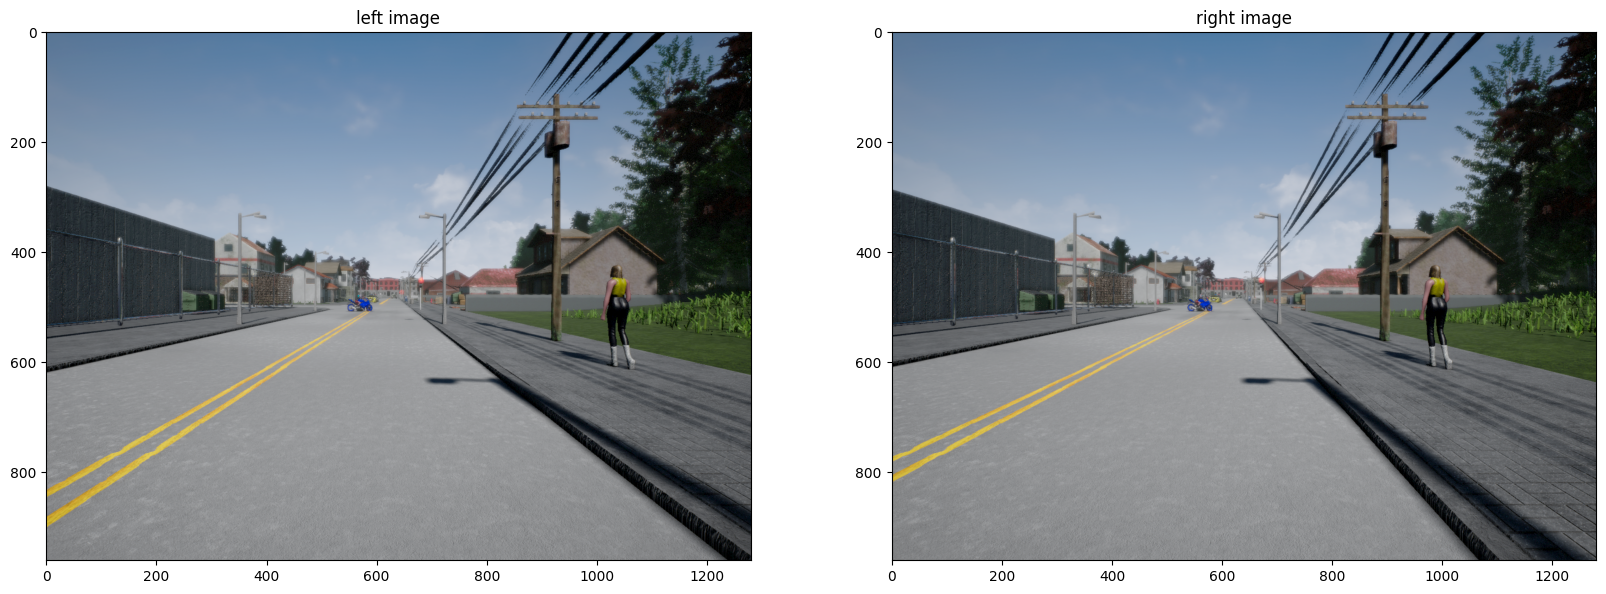

In [20]:
# Read the stereo-pair of images
img_left = files_management.read_left_image()
img_right = files_management.read_right_image()

# Use matplotlib to display the two images
_, image_cells = plt.subplots(1, 2, figsize=(20, 20))
image_cells[0].imshow(img_left)
image_cells[0].set_title('left image')
image_cells[1].imshow(img_right)
image_cells[1].set_title('right image')
plt.show()

To go with these images are their respective projection matrices. Let's run the following to gather these and print them. 

In [21]:
# Read the calibration
p_left, p_right = files_management.get_projection_matrices()

# Use regular numpy notation instead of scientific one 
np.set_printoptions(suppress=True)

print("p_left \n", p_left)
print("\np_right \n", p_right)

p_left 
 [[ 640.     0.   640.  2176. ]
 [   0.   480.   480.   552. ]
 [   0.     0.     1.     1.4]]

p_right 
 [[ 640.     0.   640.  2176. ]
 [   0.   480.   480.   792. ]
 [   0.     0.     1.     1.4]]


With this information we can move into finding the depth of the scene.

## 2 - Estimating Depth

As we covered, we can estimate the depth of a stereo scene using the following sequence of actions:
1. Determine the disparity between the two images.
2. Decompose the projection matrices into the camera intrinsic matrix $K$, and extrinsics $R$, $t$.
3. Estimate depth using what we've gathered in the two prior steps.

### 2.1 - Computing the Disparity

It's time we began exploring some OpenCV functions. The following `compute_left_disparity_map` function is expected to recieve a stereo pair of images and return a disparity map from the perspective of the left camera. 

There are two OpenCV functions that we can use to compute a disparity map [StereoBM](https://docs.opencv.org/3.4.3/d9/dba/classcv_1_1StereoBM.html) and [StereoSGBM](https://docs.opencv.org/3.4.3/d2/d85/classcv_1_1StereoSGBM.html). 

Once you've chosen the matcher to use you can call `matcher.compute(img_left, img_right)` to generate the disparity output.

**Note**: make sure you are using grayscale images for the `matcher.compute()` method. Refer to the OpenCV documentation for more information

In [ ]:
def compute_left_disparity_map(img_left, img_right):
    
    
    # Parameters
    num_disparities = int(6*16*1)
    block_size = 2
    
    min_disparity = 0
    window_size = 6
    
    img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

    # Stereo SGBM matcher
    left_matcher_SGBM = cv2.StereoSGBM_create(
        minDisparity=min_disparity,
        numDisparities=num_disparities,
        blockSize=block_size,
        P1=8 * 3 * window_size ** 2,
        P2=32 * 3 * window_size ** 2,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )

    # Compute the left disparity map
    disp_left = left_matcher_SGBM.compute(img_left, img_right).astype(np.float32)/16
    
    return disp_left

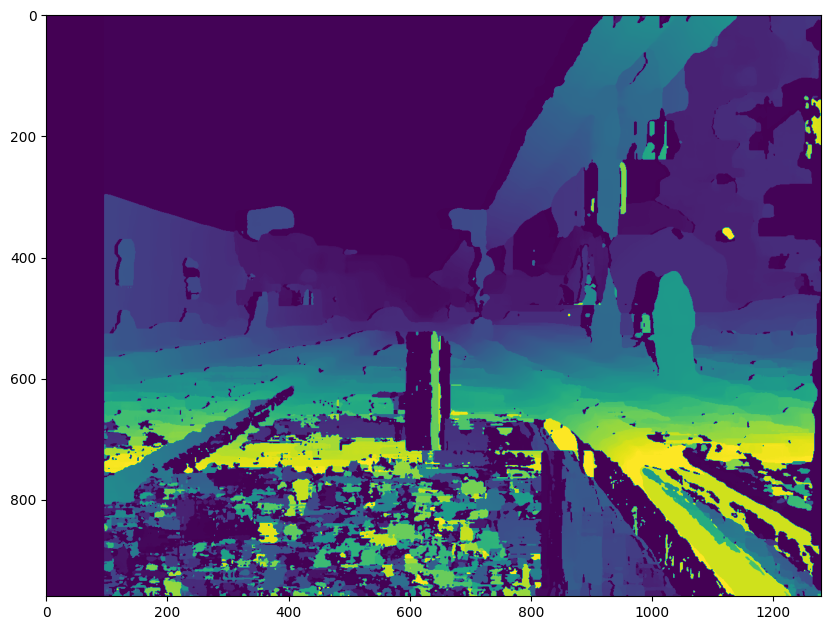

In [23]:
# Compute the disparity map using the fuction above
disp_left = compute_left_disparity_map(img_left, img_right)

# Show the left disparity map
plt.figure(figsize=(10, 10))
plt.imshow(disp_left)
plt.show()

### 2.2 - Decompose the projection matrices

How to decompose a projection matrix $P$: 

Represent $P$ as a combination of the intrinsic parameters $K$ and the extrinsic rotation $R$ and translation $t$ as follows: 
$$ $$
$$P = K[R|t]$$
$$ $$
OpenCV provides us with a single function that does all of this. Using cv2.[decomposeProjectionMatrix()](https://docs.opencv.org/3.4.3/d9/d0c/group__calib3d.html#gaaae5a7899faa1ffdf268cd9088940248). Use this function below to extract the required matrices.


**Note**: After carrying out the matrix multiplication, the homogeneous component $w_c$ will, in general, not be equal to 1. Therefore, to map back into the real plane we must perform the homogeneous divide or perspective divide by dividing each component by $w_c$

In [24]:
def decompose_projection_matrix(p):
    
    ### START CODE HERE ###
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)

    t /= t[-1]
    ### END CODE HERE ###   
    return k, r, t

The following code section uses your function above to decompose and print all of the matrices from the left and right projection matrices.

In [25]:
# Decompose each matrix
k_left, r_left, t_left = decompose_projection_matrix(p_left)
k_right, r_right, t_right = decompose_projection_matrix(p_right)

# Display the matrices
print("k_left \n", k_left)
print("\nr_left \n", r_left)
print("\nt_left \n", t_left)
print("\nk_right \n", k_right)
print("\nr_right \n", r_right)
print("\nt_right \n", t_right)

k_left 
 [[640.   0. 640.]
 [  0. 480. 480.]
 [  0.   0.   1.]]

r_left 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

t_left 
 [[-2.  ]
 [ 0.25]
 [-1.4 ]
 [ 1.  ]]

k_right 
 [[640.   0. 640.]
 [  0. 480. 480.]
 [  0.   0.   1.]]

r_right 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

t_right 
 [[-2.  ]
 [-0.25]
 [-1.4 ]
 [ 1.  ]]


### 2.3 - Generate the depth map


1. Get the focal length $f$ from the $K$ matrix
2. Compute the baseline $b$ using corresponding values from the translation vectors $t$
3. Compute depth map of the image: $$Z = \frac{f b}{x_L - x_R} = \frac{f b}{d}$$ In the above equation, $d$ is a disparity map which we have already computed in one of the previous steps in this assignment.

**Your task**: Complete the `calc_depth_map` function below to return a depth map of the same dimensions as the disparity map being provided. 

**Note:** Don't forget to address problematic disparities (the ones having of 0 and -1) to eliminate potential computational issues.

In [26]:
def calc_depth_map(disp_left, k_left, t_left, t_right):

    ### START CODE HERE ###
    
    # Get the focal length from the K matrix
    f = k_left[0, 0]

    # Get the distance between the cameras from the t matrices (baseline)
    b = np.linalg.norm(t_left[:3] - t_right[:3])

    # Replace all instances of 0 and -1 disparity with a small minimum value (to avoid div by 0 or negatives)
    disp_left[disp_left == 0] = 0.1
    disp_left[disp_left == -1] = 0.1

    # Initialize the depth map to match the size of the disparity map
    depth_map = np.zeros_like(disp_left)

    # Calculate the depths 
    depth_map = f * b / disp_left
    
    ### END CODE HERE ###
    
    return depth_map

Below we call the calc_depth_map function to generate a depth map for the disparity map we found in 2.1.

The depth map is displayed for reference.

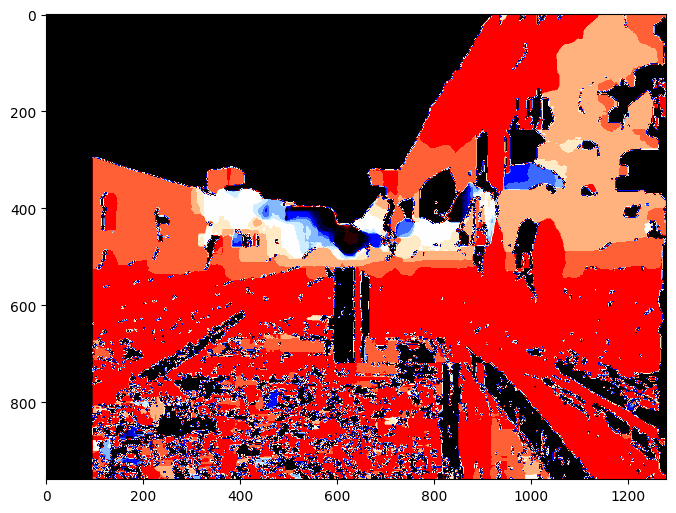

In [27]:
# Get the depth map by calling the above function
depth_map_left = calc_depth_map(disp_left, k_left, t_left, t_right)

# Display the depth map
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(depth_map_left, cmap='flag')
plt.show()

+ Excellent! Now you have successfully used a stereo pair of images to determine the depth of a scene! 
+ Congrats on finishing this assignment! 